In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns


# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import r2_score
import pickle

import eli5
from eli5.sklearn import PermutationImportance

# 컬럼 화면 설정
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 50)

In [ ]:
# %pip install catboost

In [10]:
# %pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5b/c2/ffab644d6dabb5903a3754bac87a76f3c99828ebe62261975f53472d3035/xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for nvidia-nccl-cu12 from https://files.pythonhosted.org/packages/72/3a/1ff98da19ad6d54db45e5b2a1e3fb77bd19e54b75cdb20d89f8161384dbb/nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 20.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 16.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [3]:
data_path = '../data/'

data = pd.read_csv(f'{data_path}240717_ing_not_null_3.csv')

In [4]:
df = data.copy()

In [5]:
object_col = df.select_dtypes(include=['object']).columns
object_col


Index(['시', '구', '동', '번지', '도로명', '건물명', '최단거리초등학교명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '2번째_가까운_역_이름', '2번째_가까운_역_호선', '3번째_가까운_역_이름',
       '3번째_가까운_역_호선'],
      dtype='object')

In [6]:
num_col = df.select_dtypes(include=['int64', 'float64']).columns
num_col

Index(['계약_년도', '계약_월', '계약_일', '건축년도', '층', '전용면적(㎡)', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '주차대수', '5층 동수',
       '5층 세대수', '6~10층 동수', '6~10층 세대수', '11~15층 동수', '11~15층 세대수',
       '16~20층 동수', '16~20층 세대수', '21층이상 동수', '21층이상 세대수', '세대수_수정', '좌표X_jm',
       '좌표Y_jm', '최단거리초등학교Km', '1번째_가까운_역_거리', '1번째_가까운_역_도보시간',
       '2번째_가까운_역_거리', '2번째_가까운_역_도보시간', '3번째_가까운_역_거리', '3번째_가까운_역_도보시간',
       '5분이하_역_개수', '5분초과_10분이하_역_개수', '10분초과_15분이하_역_개수', '15분초과_20분이하_역_개수',
       'target', 'is_test'],
      dtype='object')

In [7]:
# LabelEncoder 생성
label_encoder = LabelEncoder()

# object dtype을 가진 모든 열에 대해 레이블 인코딩 적용
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])

In [8]:
df.head(3)

,계약_년도,계약_월,계약_일,건축년도,시,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
0,2017,12,8,1987,0,0,8,4737,6172,329,3,79.97,20,250,0,0,262,8,270,0,0,0,0,0,0,0,0,270,127.056859,37.476276,546,0.385832,35,17,1187.672025,17.81508,104,2,1483.43809,22.251571,80,2,1633.265245,24.498979,0,0,0,1,124000.0,0
1,2017,12,22,1987,0,0,8,4737,6172,329,4,79.97,20,250,0,0,262,8,270,0,0,0,0,0,0,0,0,270,127.056859,37.476276,546,0.385832,35,17,1187.672025,17.81508,104,2,1483.43809,22.251571,80,2,1633.265245,24.498979,0,0,0,1,123500.0,0
2,2017,12,28,1987,0,0,8,4737,6172,329,5,54.98,20,250,0,0,262,8,270,0,0,0,0,0,0,0,0,270,127.056859,37.476276,546,0.385832,35,17,1187.672025,17.81508,104,2,1483.43809,22.251571,80,2,1633.265245,24.498979,0,0,0,1,91500.0,0


## 스케일

In [9]:
df_scale = df.copy()

In [10]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# Min-Max 스케일링 적용할 열 선택
# columns_to_scale = df.columns  # 모든 열을 스케일링할 경우

# 선택한 열에 Min-Max 스케일링 적용
df_scale.iloc[:,:-2] = scaler.fit_transform(df_scale.iloc[:,:-2])

print("\nDataFrame after Min-Max Scaling:")
print(df_scale)


DataFrame after Min-Max Scaling:
          계약_년도      계약_월      계약_일      건축년도    시    구         동        번지  \
0        0.6250  1.000000  0.233333  0.419355  0.0  0.0  0.023810  0.720237   
1        0.6250  1.000000  0.700000  0.419355  0.0  0.0  0.023810  0.720237   
2        0.6250  1.000000  0.900000  0.419355  0.0  0.0  0.023810  0.720237   
3        0.6875  0.000000  0.066667  0.419355  0.0  0.0  0.023810  0.720237   
4        0.6875  0.000000  0.233333  0.419355  0.0  0.0  0.023810  0.720237   
...         ...       ...       ...       ...  ...  ...       ...       ...   
1128089  1.0000  0.545455  0.600000  0.854839  0.0  1.0  0.517857  0.882013   
1128090  1.0000  0.545455  0.800000  0.854839  0.0  1.0  0.517857  0.882013   
1128091  1.0000  0.636364  0.866667  0.854839  0.0  1.0  0.517857  0.882013   
1128092  1.0000  0.727273  0.033333  0.854839  0.0  1.0  0.517857  0.882013   
1128093  1.0000  0.727273  0.100000  0.854839  0.0  1.0  0.517857  0.882013   

              도로명

In [11]:
df_scale.head(2)

,계약_년도,계약_월,계약_일,건축년도,시,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
0,0.625,1.0,0.233333,0.419355,0.0,0.0,0.02381,0.720237,0.667965,0.049985,0.095890,0.168839,0.00402,0.048714,0.0,0.0,0.02166,0.333333,0.133005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027982,0.669235,0.165172,0.917647,0.207121,0.113636,0.73913,0.316614,0.316614,0.334405,0.08,0.375455,0.375455,0.252366,0.08,0.375598,0.375598,0.0,0.0,0.0,0.0625,124000.0,0
1,0.625,1.0,0.700000,0.419355,0.0,0.0,0.02381,0.720237,0.667965,0.049985,0.109589,0.168839,0.00402,0.048714,0.0,0.0,0.02166,0.333333,0.133005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027982,0.669235,0.165172,0.917647,0.207121,0.113636,0.73913,0.316614,0.316614,0.334405,0.08,0.375455,0.375455,0.252366,0.08,0.375598,0.375598,0.0,0.0,0.0,0.0625,123500.0,0


In [12]:
df_scale.loc[df_scale['is_test']==0, 'target'].mean() # 57991

57991.532148992424

In [13]:
trainset = df_scale[df_scale['is_test']==0]
sub_set = df_scale[df_scale['is_test']==1]

In [14]:
del df_scale

In [15]:
X = trainset.iloc[:,:-2]
y = trainset.iloc[:,-2]
y

0          124000.0
1          123500.0
2           91500.0
3          130000.0
4          117000.0
             ...   
1118817     20000.0
1118818     20000.0
1118819     28000.0
1118820     29000.0
1118821     13250.0
Name: target, Length: 1118822, dtype: float64

In [16]:
submission = sub_set.iloc[:,:-2]

In [17]:
submission.reset_index(drop=True, inplace=True)

In [18]:
submission.head(1)
submission.shape

(9272, 48)

# X를 연, 월, 일 순서로 정렬함. 혹시 똥망이면 수정하기

In [19]:
# X = X.sort_values(['계약_년도', '계약_월', '계약_일'])

In [20]:
X['계약_년도'].value_counts().sort_index()

0.0000     58767
0.0625     57012
0.1250     73491
0.1875     44457
0.2500     54513
0.3125     40851
0.3750     67865
0.4375     85130
0.5000    119891
0.5625     99253
0.6250    104893
0.6875     81413
0.7500     74696
0.8125     83711
0.8750     43117
0.9375     12214
1.0000     17548
Name: 계약_년도, dtype: int64

In [21]:
X.loc[X['계약_년도']==1.0000, '계약_월'].value_counts().sort_index()

0.000000    1488
0.090909    2539
0.181818    2889
0.272727    3265
0.363636    3500
0.454545    3867
Name: 계약_월, dtype: int64

In [22]:
# Train-Validation-Test 데이터 분할
# X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
X_train # 906245
#X_valid # 100694
X_test #  111883

,계약_년도,계약_월,계약_일,건축년도,시,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
214319,0.1250,0.272727,0.000000,0.645161,0.0,0.125000,0.633929,0.360347,0.094697,0.441355,0.246575,0.253094,0.002412,0.020460,0.032625,0.0,0.023892,0.0,0.0,0.00000,0.00000,0.053571,0.045839,0.000000,0.000000,0.000000,0.000000,0.021250,0.183099,0.448303,0.630252,0.262228,0.737013,0.347826,0.026366,0.026366,0.623794,0.36,0.208800,0.208800,0.299685,0.36,0.188939,0.188939,0.2,0.000,0.222222,0.0000
150044,0.1250,0.454545,0.166667,0.548387,0.0,0.125000,0.633929,0.326897,0.654437,0.000152,0.178082,0.126973,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000631,0.175726,0.461405,0.658824,0.041767,0.737013,0.347826,0.143878,0.143878,0.292605,0.36,0.133568,0.133568,0.889590,0.36,0.252060,0.252060,0.0,0.250,0.000000,0.1250
505741,0.6250,0.727273,0.700000,0.725806,0.0,0.583333,0.449405,0.121940,0.522294,0.279398,0.150685,0.155153,0.000000,0.109119,0.157625,0.0,0.117560,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103724,0.574731,0.258939,0.443697,0.170715,0.600649,0.869565,0.157597,0.157597,0.601286,0.36,0.145155,0.145155,0.018927,0.04,0.132983,0.132983,0.0,0.375,0.333333,0.3125
859426,0.3750,0.727273,0.333333,0.677419,0.0,0.166667,0.369048,0.233389,0.564502,0.080826,0.164384,0.120275,0.209849,0.286048,0.378299,0.0,0.446759,0.0,0.0,0.00000,0.00000,0.017857,0.009791,0.119048,0.066456,0.584615,0.474940,0.229329,0.385688,0.218436,0.129412,0.208385,0.584416,0.260870,0.198598,0.198598,0.501608,0.04,0.240292,0.240292,0.422713,0.04,0.255153,0.255153,0.0,0.000,0.222222,0.0625
207566,1.0000,0.454545,0.266667,0.500000,0.0,0.250000,0.059524,0.103543,0.229221,0.266636,0.150685,0.148154,0.040603,0.043843,0.000000,0.0,0.020337,0.0,0.0,0.00000,0.00000,0.035714,0.095016,0.000000,0.000000,0.000000,0.000000,0.044498,0.234772,0.227368,0.248739,0.131803,0.220779,0.043478,0.037016,0.037016,0.228296,0.24,0.063382,0.063382,0.173502,0.24,0.200212,0.200212,0.4,0.000,0.222222,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734111,0.4375,0.909091,0.133333,0.338710,0.0,0.708333,0.000000,0.578531,0.573918,0.553023,0.068493,0.046029,0.573668,1.000000,0.549853,0.0,1.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,1.000000,1.000000,0.646154,0.709278,1.000000,0.803138,0.249880,0.028571,0.135622,0.561688,0.304348,0.131663,0.131663,0.527331,0.40,0.205543,0.205543,0.533123,0.32,0.194329,0.194329,0.0,0.125,0.222222,0.3125
744838,0.5000,0.090909,0.900000,0.548387,0.0,0.750000,0.556548,0.103087,0.604762,0.945913,0.315068,0.180594,0.000000,0.042284,0.000000,0.0,0.017526,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.023810,0.045636,0.000000,0.000000,0.022407,0.182510,0.326638,0.549580,0.085732,0.756494,0.173913,0.216472,0.216472,0.250804,0.04,0.196466,0.196466,0.703470,0.04,0.208327,0.208327,0.0,0.000,0.333333,0.0625
251138,0.8750,0.000000,0.133333,0.645161,0.0,0.208333,0.068452,0.273985,0.131602,0.428897,0.328767,0.294617,0.000000,0.014030,0.025660,0.0,0.051587,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.015385,0.037589,0.026089,0.770576,0.416465,0.121008,0.206313,0.032468,0.043478,0.139837,0.139837,0.128617,0.04,0.209335,0.209335,0.094637,0.16,0.219441,0.219441,0.0,0.125,0.222222,0.0000
60264,0.6250,1.000000,0.200000,0.483871,0.0,0.583333,0.589286,0.187471,0.400649,0.689760,0.232877,0.180690,0.000000,0.165238,0.000000,0.0,0.090939,0.0,0.

In [24]:
y_train # 906245
#y_valid # 100694
y_test #  111883

214319     56000.0
150044     19000.0
505741    110000.0
859426     28500.0
207566     64200.0
            ...   
734111     45000.0
744838     44900.0
251138    151500.0
60264      89000.0
492283     45200.0
Name: target, Length: 111883, dtype: float64

In [41]:
def get_score(model, x_train, x_test, y_train, y_test):
    y_pred1 = model.predict(X_train)
#    y_pred2 = model.predict(X_valid)
    y_pred3 = model.predict(X_test)

    # 음수값 보정
    y_pred1 = np.where(y_pred1 < 0, 57991, y_pred1)   # mean 57991
#    y_pred2 = np.where(y_pred2 < 0, 57991, y_pred2)   # mean 57991
    y_pred3 = np.where(y_pred3 < 0, 57991, y_pred3)   # mean 57991    

    A = r2_score(y_train, y_pred1)
#    B = r2_score(y_valid, y_pred2)
    C = r2_score(y_test, y_pred3)    
    #C = model.score(x_train, y_train)  # r2_score (결정계수)
    #D = model.score(x_test, y_test)
    D = MSE(y_train, y_pred1) ** 0.5
#    E = MSE(y_valid, y_pred2) ** 0.5
    F = MSE(y_test, y_pred3) ** 0.5

    G = MSLE(y_train, y_pred1) ** 0.5
#    H = MSLE(y_valid, y_pred2) ** 0.5
    I = MSLE(y_test, y_pred3) ** 0.5    
    
    J = MAPE(y_train, y_pred1)
#    K = MAPE(y_valid, y_pred2)
    L = MAPE(y_test, y_pred3)
#    return f'r2: {A:.4f} {B:.4f} / rmse: {D:.4f} {E:.4f} / rmsle: {G:.4f} {H:.4f} / mape: {J:.4f} {K:.4f}'
    return f'r2: {A:.4f} {C:.4f} / rmse: {D:.4f} {F:.4f} / rmsle: {G:.4f} {I:.4f} / mape: {J:.4f} {L:.4f}'

In [26]:
# def get_score(model, X_train, X_valid, X_test, y_train, y_valid, y_test):
#     y_pred1 = model.predict(X_train)
#     y_pred2 = model.predict(X_valid)
#     y_pred3 = model.predict(X_test)

#     # 음수값 보정
#     y_pred1 = np.where(y_pred1 < 0, 57991, y_pred1)   # mean 57991
#     y_pred2 = np.where(y_pred2 < 0, 57991, y_pred2)   # mean 57991
#     y_pred3 = np.where(y_pred3 < 0, 57991, y_pred3)   # mean 57991    

#     A = r2_score(y_train, y_pred1)
#     B = r2_score(y_valid, y_pred2)
#     C = r2_score(y_test, y_pred3)    
#     #C = model.score(x_train, y_train)  # r2_score (결정계수)
#     #D = model.score(x_test, y_test)
#     D = MSE(y_train, y_pred1) ** 0.5
#     E = MSE(y_valid, y_pred2) ** 0.5
#     F = MSE(y_test, y_pred3) ** 0.5

#     G = MSLE(y_train, y_pred1) ** 0.5
#     H = MSLE(y_valid, y_pred2) ** 0.5
#     I = MSLE(y_test, y_pred3) ** 0.5    
    
#     J = MAPE(y_train, y_pred1)
#     K = MAPE(y_valid, y_pred2)
#     L = MAPE(y_test, y_pred3)
#     return f'r2: {A:.4f} {B:.4f} {C:.4f}  / rmse: {D:.4f} {E:.4f} {F:.4f}  / rmsle: {G:.4f} {H:.4f} {H:.4f}  / mape: {J:.4f} {K:.4f} {L:.4f}'

In [27]:
X_sample = X_train.iloc[:200000, :]
y_sample = y_train[:200000]

In [28]:
X_train

,계약_년도,계약_월,계약_일,건축년도,시,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
237561,0.9375,0.727273,0.200000,0.806452,0.0,0.958333,0.520833,0.901323,0.899351,0.815406,0.068493,0.180859,0.018693,0.090608,0.054985,0.0,0.082837,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077109,0.562156,0.497644,0.968067,0.099364,0.912338,0.217391,0.060755,0.060755,0.909968,0.16,0.059923,0.059923,0.611987,0.20,0.138243,0.138243,0.4,0.250,0.666667,0.2500
790299,0.4375,0.727273,0.066667,0.435484,0.0,0.333333,0.416667,0.716588,0.306277,0.449407,0.219178,0.121844,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101304,0.666512,0.913819,0.258824,0.092594,0.308442,0.260870,0.046377,0.046377,0.385852,0.48,0.258404,0.258404,0.201893,0.24,0.293799,0.293799,0.2,0.000,0.000000,0.1875
420681,0.6875,1.000000,0.133333,0.516129,0.0,0.541667,0.961310,0.883229,0.920238,0.976907,0.095890,0.180425,0.000000,0.165238,0.054985,0.0,0.069031,0.0,0.0,0.02439,0.042945,0.160714,0.209613,0.000000,0.000000,0.000000,0.000000,0.104566,0.376382,0.587374,0.094118,0.183103,0.353896,0.086957,0.074924,0.074924,0.974277,0.08,0.176170,0.176170,0.264984,0.08,0.305549,0.305549,0.2,0.000,0.111111,0.0000
296419,0.8125,0.545455,0.100000,0.887097,0.0,0.000000,0.187500,0.983579,0.174892,0.908235,0.123288,0.180705,0.000000,0.018316,0.005865,0.0,0.012897,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.023810,0.023134,0.000000,0.000000,0.011151,0.622073,0.210453,0.636975,0.137235,0.694805,0.826087,0.155470,0.155470,0.694534,0.08,0.142659,0.142659,0.340694,0.08,0.147624,0.147624,0.0,0.250,0.111111,0.0000
1037733,0.0625,0.363636,0.766667,0.516129,0.0,0.333333,0.809524,0.453094,0.840260,0.814494,0.219178,0.254526,0.000000,0.000000,0.351906,0.0,0.111855,0.0,0.0,0.00000,0.000000,0.303571,0.213618,0.000000,0.000000,0.000000,0.000000,0.100568,0.729773,0.858901,0.383193,0.076746,0.457792,0.130435,0.299631,0.299631,0.199357,0.12,0.382657,0.382657,0.873817,0.24,0.360798,0.360798,0.0,0.000,0.000000,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.2500,0.909091,0.000000,0.435484,0.0,0.333333,0.416667,0.819371,0.305303,0.449104,0.219178,0.075501,0.325226,0.086906,0.000000,0.0,0.076637,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192510,0.679748,0.842918,0.196639,0.118674,0.870130,0.260870,0.124841,0.124841,0.199357,0.24,0.190228,0.190228,0.201893,0.12,0.214868,0.214868,0.0,0.125,0.333333,0.1250
259178,0.8750,0.454545,0.533333,0.435484,0.0,0.333333,0.416667,0.548578,0.950000,0.918870,0.219178,0.180787,0.064523,0.029228,0.000000,0.0,0.015708,0.0,0.0,0.00000,0.000000,0.053571,0.104806,0.000000,0.000000,0.000000,0.000000,0.049127,0.699145,0.909646,0.085714,0.153585,0.457792,0.130435,0.171141,0.171141,0.199357,0.12,0.258780,0.258780,0.318612,0.24,0.204740,0.204740,0.0,0.125,0.111111,0.1875
131932,0.3125,0.636364,0.633333,0.693548,0.0,0.875000,0.380952,0.758705,0.460281,0.398511,0.178082,0.180594,0.019296,0.027864,0.006232,0.0,0.022900,0.0,0.0,0.00000,0.000000,0.017857,0.006231,0.047619,0.047950,0.000000,0.000000,0.026510,0.329169,0.754135,0.647059,0.080931,0.256494,0.217391,0.221093,0.221093,0.733119,0.08,0.251817,0.251817,0.735016,0.20,0.244315,0.244315,0.0,0.000,0.111111,0.1250
671155,0.4375,0.818182,0.966667,0.629032,0.0,0.166667,0.369048,0.231412,0.096970,0.393953,0.301370,0.252860,0.088442,0.145557,0.150293,0.0,0.146

In [29]:
# model1 = LinearRegression().fit(X_train, y_train)
# print(' LinearRegression\n',get_score(model1, X_train, X_test, y_train, y_test))

# # 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
# with open('model1.pkl', 'wb') as f:
#     pickle.dump(model1, f)

# LinearRegression
#  r2: 0.5774 0.5794 / rmse: 30152.6225 30350.8628 / rmsle: 0.5652 0.5625 / mape: 0.4364 0.4349

In [30]:
# model2 = DecisionTreeRegressor(max_depth=200).fit(X_train, y_train)
# print(' DecisionTree\n',get_score(model2, X_train, X_test, y_train,y_test))

# # 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
# with open('model2.pkl', 'wb') as f:
#     pickle.dump(model2, f)

#     DecisionTree
#  r2: 1.0000 0.9665 / rmse: 189.4237 8564.4209 / rmsle: 0.0048 0.1095 / mape: 0.0002 0.0648

In [31]:
model3 = RandomForestRegressor(max_depth=30, n_estimators=100, random_state=42).fit(X_train, y_train)
print(' RandomForest\n',get_score(model3, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model3.pkl', 'wb') as f:
    pickle.dump(model3, f)

 RandomForest
 r2: 0.9976 0.9824 / rmse: 2287.9534 6208.6108 / rmsle: 0.0348 0.0792 / mape: 0.0189 0.0484


#### 240719 00시 기준으로 랜덤포레스트 nestimators 100이 제일 나음

In [47]:
model3_3 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' RandomForest\n',get_score(model3_3, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model3.pkl', 'wb') as f:
    pickle.dump(model3_3, f)

 RandomForest
 r2: 0.9976 0.9824 / rmse: 2253.7412 6209.4843 / rmsle: 0.0339 0.0792 / mape: 0.0179 0.0484


In [32]:
model4 = GradientBoostingRegressor(max_depth=30, n_estimators=100, random_state=42).fit(X_train, y_train)
print(' GradientBoosting\n',get_score(model4, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model4.pkl', 'wb') as f:
    pickle.dump(model4, f)

 GradientBoosting
 r2: 1.0000 0.9700 / rmse: 189.4510 8110.1716 / rmsle: 0.0048 0.1021 / mape: 0.0002 0.0609


In [48]:
model4_2 = GradientBoostingRegressor(max_depth=15, n_estimators=100, random_state=42).fit(X_train, y_train)
print(' GradientBoosting\n',get_score(model4_2, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model4.pkl', 'wb') as f:
    pickle.dump(model4_2, f)

 GradientBoosting
 r2: 0.9982 0.9836 / rmse: 1979.8450 5988.9642 / rmsle: 0.0442 0.0767 / mape: 0.0291 0.0472


In [33]:
model5 = AdaBoostRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' AdaBoost\n',get_score(model5, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model5.pkl', 'wb') as f:
    pickle.dump(model5, f)

 AdaBoost
 r2: -2.7686 -2.7059 / rmse: 90045.4503 90095.6641 / rmsle: 1.2256 1.2261 / mape: 2.4859 2.4874


In [49]:
model5_2 = AdaBoostRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' AdaBoost\n',get_score(model5_2, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model5.pkl', 'wb') as f:
    pickle.dump(model5_2, f)

 AdaBoost
 r2: -2.7686 -2.7059 / rmse: 90045.4503 90095.6641 / rmsle: 1.2256 1.2261 / mape: 2.4859 2.4874


In [37]:
model6 = lgb.LGBMRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9513 0.9492 / rmse: 10237.9423 10551.2044 / rmsle: 0.1564 0.1572 / mape: 0.1190 0.1195


In [38]:
model6_2 = lgb.LGBMRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_2, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_2, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9660 0.9633 / rmse: 8558.5222 8964.0764 / rmsle: 0.1365 0.1374 / mape: 0.1006 0.1013


In [44]:
model6_2_m = lgb.LGBMRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_2_m, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_2_m, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9660 0.9633 / rmse: 8558.5222 8964.0764 / rmsle: 0.1365 0.1374 / mape: 0.1006 0.1013


In [39]:
model6_3 = lgb.LGBMRegressor(n_estimators=1000, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_3, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_3, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9839 0.9792 / rmse: 5881.9703 6754.5189 / rmsle: 0.0981 0.1016 / mape: 0.0685 0.0699


In [43]:
model6_3_m = lgb.LGBMRegressor(n_estimators=1000, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_3_m, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_3_m, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9839 0.9792 / rmse: 5881.9703 6754.5189 / rmsle: 0.0981 0.1016 / mape: 0.0685 0.0699


In [42]:
model6_4 = lgb.LGBMRegressor(n_estimators=2000, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_4, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_4, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9883 0.9824 / rmse: 5026.0898 6213.5196 / rmsle: 0.0857 0.0906 / mape: 0.0584 0.0604


In [45]:
model6_5 = lgb.LGBMRegressor(n_estimators=3000, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_5, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_5, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9903 0.9836 / rmse: 4568.6878 5996.2577 / rmsle: 0.0794 0.0847 / mape: 0.0533 0.0560


In [46]:
model6_6 = lgb.LGBMRegressor(n_estimators=600, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_6, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_6, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9798 0.9757 / rmse: 6595.7171 7288.6078 / rmsle: 0.1090 0.1108 / mape: 0.0776 0.0786


In [59]:
model6_7 = lgb.LGBMRegressor(n_estimators=500, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_7, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_7, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9780 0.9742 / rmse: 6880.9508 7517.5199 / rmsle: 0.1135 0.1150 / mape: 0.0812 0.0821


In [60]:
model6_8 = lgb.LGBMRegressor(n_estimators=50, random_state=42).fit(X_train, y_train)
print(' LGBM\n',get_score(model6_8, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model6.pkl', 'wb') as f:
    pickle.dump(model6_8, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7183
[LightGBM] [Info] Number of data points in the train set: 1006939, number of used features: 47
[LightGBM] [Info] Start training from score 57989.561139
 LGBM
 r2: 0.9265 0.9242 / rmse: 12573.7083 12886.5221 / rmsle: 0.1883 0.1883 / mape: 0.1486 0.1485


In [36]:
# import lightgbm as lgb

# # GPU를 사용하여 LightGBM 모델 초기화
# params = {
#     'n_estimators': 100,
#     'random_state': 42,
#     'device': 'cuda',  # GPU 사용 설정
#     'gpu_platform_id': 0,  # 사용할 GPU 플랫폼 ID
#     'gpu_device_id': 0  # 사용할 GPU 장치 ID
# }

# model6 = lgb.LGBMRegressor(**params)
# model6.fit(X_train, y_train)

# # 성능 평가 및 모델 저장은 기존과 동일하게 진행
# print('LGBM\n', get_score(model, X_train, X_test, y_train, y_test))

# # 학습된 모델 저장
# with open('model_lgbm.pkl', 'wb') as f:
#     pickle.dump(model6, f)


[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1

In [ ]:
# import lightgbm as lgb

# # GPU를 사용하여 LightGBM 모델 초기화
# params = {
#     'n_estimators': 200,
#     'random_state': 42,
#     'device': 'gpu',  # GPU 사용 설정
#     'gpu_platform_id': 0,  # 사용할 GPU 플랫폼 ID
#     'gpu_device_id': 0  # 사용할 GPU 장치 ID
# }

# model6_2 = lgb.LGBMRegressor(**params)
# model6_2.fit(X_train, y_train)

# # 성능 평가 및 모델 저장은 기존과 동일하게 진행
# print('LGBM\n', get_score(model, X_train, X_test, y_train, y_test))

# # 학습된 모델 저장
# with open('model_lgbm.pkl', 'wb') as f:
#     pickle.dump(model6_2, f)


In [50]:
model7 = xgb.XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' XGB\n',get_score(model7, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model.pkl', 'wb') as f:
    pickle.dump(model7, f)

 XGB
 r2: 0.9688 0.9649 / rmse: 8195.0186 8767.8543 / rmsle: 0.1347 0.1364 / mape: 0.0959 0.0968


In [51]:
# #model = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')
# # CatBoost 모델 설정 및 학습
# model8 = cb.CatBoostRegressor(max_depth=5, n_estimators=100, random_state=42).fit(X_train, y_train)
# print(' XGB\n',get_score(model7, X_train, X_test, y_train, y_test))
# # model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, early_stopping_rounds=50)
# # 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
# with open('model8.pkl', 'wb') as f:
#     pickle.dump(model8, f)

Learning rate set to 0.5
0:	learn: 35108.5466865	total: 84.4ms	remaining: 8.35s
1:	learn: 29115.7999783	total: 116ms	remaining: 5.68s
2:	learn: 25576.3155542	total: 143ms	remaining: 4.63s
3:	learn: 23415.8348601	total: 172ms	remaining: 4.13s
4:	learn: 21702.2606820	total: 204ms	remaining: 3.88s
5:	learn: 20514.1759045	total: 232ms	remaining: 3.64s
6:	learn: 19441.2903296	total: 264ms	remaining: 3.5s
7:	learn: 18715.9993838	total: 295ms	remaining: 3.39s
8:	learn: 18110.0464513	total: 328ms	remaining: 3.31s
9:	learn: 17653.0463769	total: 356ms	remaining: 3.2s
10:	learn: 17300.2986145	total: 386ms	remaining: 3.12s
11:	learn: 17029.3765648	total: 416ms	remaining: 3.05s
12:	learn: 16692.8869732	total: 447ms	remaining: 2.99s
13:	learn: 16320.5948561	total: 479ms	remaining: 2.94s
14:	learn: 16108.2870818	total: 505ms	remaining: 2.86s
15:	learn: 15919.1814444	total: 535ms	remaining: 2.81s
16:	learn: 15541.7834340	total: 569ms	remaining: 2.78s
17:	learn: 15407.6481499	total: 597ms	remaining: 2.

In [52]:
#model = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')
# CatBoost 모델 설정 및 학습
model8_2 = cb.CatBoostRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
print(' XGB\n',get_score(model8_2, X_train, X_test, y_train, y_test))
# model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, early_stopping_rounds=50)
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model8.pkl', 'wb') as f:
    pickle.dump(model8_2, f)

Learning rate set to 0.5
0:	learn: 34073.8820416	total: 43.1ms	remaining: 4.26s
1:	learn: 27383.6248414	total: 76.1ms	remaining: 3.73s
2:	learn: 23395.9095635	total: 110ms	remaining: 3.57s
3:	learn: 21360.7565762	total: 143ms	remaining: 3.44s
4:	learn: 19975.7903449	total: 179ms	remaining: 3.4s
5:	learn: 18974.4669708	total: 215ms	remaining: 3.37s
6:	learn: 18200.8700396	total: 252ms	remaining: 3.34s
7:	learn: 17528.6935713	total: 288ms	remaining: 3.31s
8:	learn: 17072.8353419	total: 321ms	remaining: 3.24s
9:	learn: 16675.0805458	total: 354ms	remaining: 3.19s
10:	learn: 16342.4697033	total: 389ms	remaining: 3.15s
11:	learn: 15966.8303573	total: 425ms	remaining: 3.11s
12:	learn: 15651.2589862	total: 457ms	remaining: 3.06s
13:	learn: 15381.8989744	total: 492ms	remaining: 3.02s
14:	learn: 15184.8779256	total: 524ms	remaining: 2.97s
15:	learn: 14980.2122872	total: 560ms	remaining: 2.94s
16:	learn: 14768.3630954	total: 595ms	remaining: 2.9s
17:	learn: 14614.1592327	total: 623ms	remaining: 2

In [53]:
#model = cb.CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')
# CatBoost 모델 설정 및 학습
model8_3 = cb.CatBoostRegressor(max_depth=10, n_estimators=100, random_state=42).fit(X_train, y_train)
print(' XGB\n',get_score(model8_3, X_train, X_test, y_train, y_test))
# model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, early_stopping_rounds=50)
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model8.pkl', 'wb') as f:
    pickle.dump(model8_3, f)

Learning rate set to 0.5
0:	learn: 31084.0855240	total: 95.3ms	remaining: 9.43s
1:	learn: 22836.2987445	total: 188ms	remaining: 9.21s
2:	learn: 18868.8532170	total: 281ms	remaining: 9.08s
3:	learn: 16682.0212789	total: 373ms	remaining: 8.95s
4:	learn: 15334.8774359	total: 465ms	remaining: 8.83s
5:	learn: 14482.1401225	total: 555ms	remaining: 8.7s
6:	learn: 13919.7833108	total: 647ms	remaining: 8.59s
7:	learn: 13488.6692718	total: 742ms	remaining: 8.53s
8:	learn: 12957.9139246	total: 840ms	remaining: 8.49s
9:	learn: 12653.1669580	total: 935ms	remaining: 8.41s
10:	learn: 12329.1769429	total: 1.02s	remaining: 8.29s
11:	learn: 12062.6165511	total: 1.12s	remaining: 8.2s
12:	learn: 11831.5465498	total: 1.21s	remaining: 8.1s
13:	learn: 11506.2788496	total: 1.3s	remaining: 8s
14:	learn: 11308.8984562	total: 1.39s	remaining: 7.9s
15:	learn: 11175.4899132	total: 1.49s	remaining: 7.81s
16:	learn: 11024.9458158	total: 1.58s	remaining: 7.72s
17:	learn: 10786.2015434	total: 1.67s	remaining: 7.63s
18

In [54]:
model3_2 = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42).fit(X_train, y_train)
print(' RandomForest\n',get_score(model3_2, X_train, X_test, y_train, y_test))

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model3.pkl', 'wb') as f:
    pickle.dump(model3_2, f)

 RandomForest
 r2: 0.8885 0.8848 / rmse: 15491.4641 15884.2917 / rmsle: 0.2161 0.2176 / mape: 0.1729 0.1745


In [38]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import r2_score, mean_squared_error
# import matplotlib.pyplot as plt
# import numpy as np

In [38]:


# # 데이터 준비 (X는 특성, y는 타겟 변수)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 하이퍼파라미터 설정
# param_grid = {
#     'max_depth': [1,2],
#     'n_estimators': [1,2]
# }

# # 모델 초기화
# model = RandomForestRegressor(random_state=42)

# # 그리드 서치 설정
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# # 그리드 서치 실행
# grid_search.fit(X_train, y_train)

# # 그리드 서치 결과 확인
# results = grid_search.cv_results_
# params = results['params']
# mean_train_scores = np.sqrt(-results['mean_train_score'])  # Train RMSE
# mean_test_scores = np.sqrt(-results['mean_test_score'])    # Validation RMSE

# # 그래프 출력
# plt.figure(figsize=(12, 6))
# plt.errorbar(range(len(params)), mean_train_scores, label='Train RMSE', fmt='o')
# plt.errorbar(range(len(params)), mean_test_scores, label='Validation RMSE', fmt='o')
# plt.xticks(range(len(params)), params, rotation=45)
# plt.xlabel('Parameter Set')
# plt.ylabel('RMSE')
# plt.title('Random Forest Grid Search Results')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 최적의 파라미터 출력
# print("Best parameters found: ", grid_search.best_params_)
# print("Lowest RMSE found: ", np.sqrt(-grid_search.best_score_))

# # 최적의 파라미터로 최종 모델 학습
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

# # 테스트 데이터 예측 및 평가
# y_pred = best_model.predict(X_test)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# test_r2 = r2_score(y_test, y_pred)
# print(f"Test RMSE: {test_rmse:.4f}")
# print(f"Test R^2: {test_r2:.4f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


KeyError: 'mean_train_score'

In [39]:
# # RandomForestRegressor
# rf = RandomForestRegressor(random_state=42)

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# rf_param_grid = {
#     'n_estimators': [1,2,3],
#     'max_depth': [None, 1,2,3],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# # rf_param_grid = {
# #     'n_estimators': [100, 200, 300],
# #     'max_depth': [None, 10, 20, 30],
# #     'min_samples_split': [2, 5, 10],
# #     'min_samples_leaf': [1, 2, 4]
# # }

# rf_grid_search = GridSearchCV(rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# rf_grid_search.fit(X_train, y_train)
# rf_best = rf_grid_search.best_estimator_

# # 테스트 세트 예측 및 평가
# rf_pred = rf_best.predict(X_test)
# rf_mse = mean_squared_error(y_test, rf_pred)
# print(f'RandomForest Test MSE: {rf_mse}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [ ]:
# # AdaBoostRegressor
# ada = AdaBoostRegressor(random_state=42)

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# ada_param_grid = {
#     'n_estimators': [2,4,6],
#     'learning_rate': [0.01, 0.1, 1.0]
# }

# # ada_param_grid = {
# #     'n_estimators': [50, 100, 200],
# #     'learning_rate': [0.01, 0.1, 1.0]
# # }

# ada_grid_search = GridSearchCV(ada, param_grid=ada_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# ada_grid_search.fit(X_train, y_train)
# ada_best = ada_grid_search.best_estimator_

# # 테스트 세트 예측 및 평가
# ada_pred = ada_best.predict(X_test)
# ada_mse = mean_squared_error(y_test, ada_pred)
# print(f'AdaBoost Test MSE: {ada_mse}')


In [ ]:
# # XGBRegressor
# xgb = XGBRegressor(random_state=42)

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# xgb_param_grid = {
#     'n_estimators': [2,4,6],
#     'max_depth': [1,2,3],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# # xgb_param_grid = {
# #     'n_estimators': [100, 200, 300],
# #     'max_depth': [3, 4, 5],
# #     'learning_rate': [0.01, 0.1, 0.2],
# #     'gamma': [0, 0.1, 0.2],
# #     'subsample': [0.8, 1.0],
# #     'colsample_bytree': [0.8, 1.0]
# # }

# xgb_grid_search = GridSearchCV(xgb, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# xgb_grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)
# xgb_best = xgb_grid_search.best_estimator_

# # 테스트 세트 예측 및 평가
# xgb_pred = xgb_best.predict(X_test)
# xgb_mse = mean_squared_error(y_test, xgb_pred)
# print(f'XGBoost Test MSE: {xgb_mse}')


In [ ]:
# # CatBoostRegressor
# catboost = CatBoostRegressor(random_state=42, verbose=False)

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# catboost_param_grid = {
#     'iterations': [5,10,15],
#     'depth': [1,2,3],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# # # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# # catboost_param_grid = {
# #     'iterations': [100, 200, 300],
# #     'depth': [4, 6, 8],
# #     'learning_rate': [0.01, 0.1, 0.2]
# # }

# catboost_grid_search = GridSearchCV(catboost, param_grid=catboost_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# catboost_grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test))
# catboost_best = catboost_grid_search.best_estimator_

# # 테스트 세트 예측 및 평가
# catboost_pred = catboost_best.predict(X_test)
# catboost_mse = mean_squared_error(y_test, catboost_pred)
# print(f'CatBoost Test MSE: {catboost_mse}')


In [ ]:
# # LGBMRegressor
# lgbm = LGBMRegressor(random_state=42)

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
# lgbm_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# lgbm_grid_search = GridSearchCV(lgbm, param_grid=lgbm_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# lgbm_grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)
# lgbm_best = lgbm_grid_search.best_estimator_

# # 테스트 세트 예측 및 평가
# lgbm_pred = lgbm_best.predict(X_test)
# lgbm_mse = mean_squared_error(y_test, lgbm_pred)
# print(f'LightGBM Test MSE: {lgbm_mse}')


In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # 데이터 준비 (X는 특성, y는 타겟 변수)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 개별 모델 정의
# models = {
#     'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
#     'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
#     'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
#     'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
#     'LinearRegression': LinearRegression()
# }

# # 각 모델 학습 및 예측
# predictions = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     predictions[name] = model.predict(X_test)

# # 앙상블 (평균) 예측
# ensemble_pred = np.mean([pred for pred in predictions.values()], axis=0)

# # 개별 모델 및 앙상블 모델의 성능 평가
# for name, pred in predictions.items():
#     mse = mean_squared_error(y_test, pred)
#     r2 = r2_score(y_test, pred)
#     print(f"{name} - RMSE: {np.sqrt(mse):.4f}, R2: {r2:.4f}")

# # 앙상블 모델 성능 평가
# ensemble_mse = mean_squared_error(y_test, ensemble_pred)
# ensemble_r2 = r2_score(y_test, ensemble_pred)
# print(f"Ensemble - RMSE: {np.sqrt(ensemble_mse):.4f}, R2: {ensemble_r2:.4f}")

# # 가중치 기반 앙상블 (선택사항)
# # 각 모델의 성능에 따라 가중치를 조정할 수 있습니다
# weights = {
#     'RandomForest': 0.25,
#     'GradientBoosting': 0.2,
#     'LightGBM': 0.25,
#     'XGBoost': 0.25,
#     'LinearRegression': 0.05
# }

# weighted_ensemble_pred = np.sum([weights[name] * pred for name, pred in predictions.items()], axis=0)

# # 가중치 기반 앙상블 성능 평가
# weighted_ensemble_mse = mean_squared_error(y_test, weighted_ensemble_pred)
# weighted_ensemble_r2 = r2_score(y_test, weighted_ensemble_pred)
# print(f"Weighted Ensemble - RMSE: {np.sqrt(weighted_ensemble_mse):.4f}, R2: {weighted_ensemble_r2:.4f}")

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model8.pkl', 'wb') as f:
    pickle.dump(model, f)

### 변수중요도

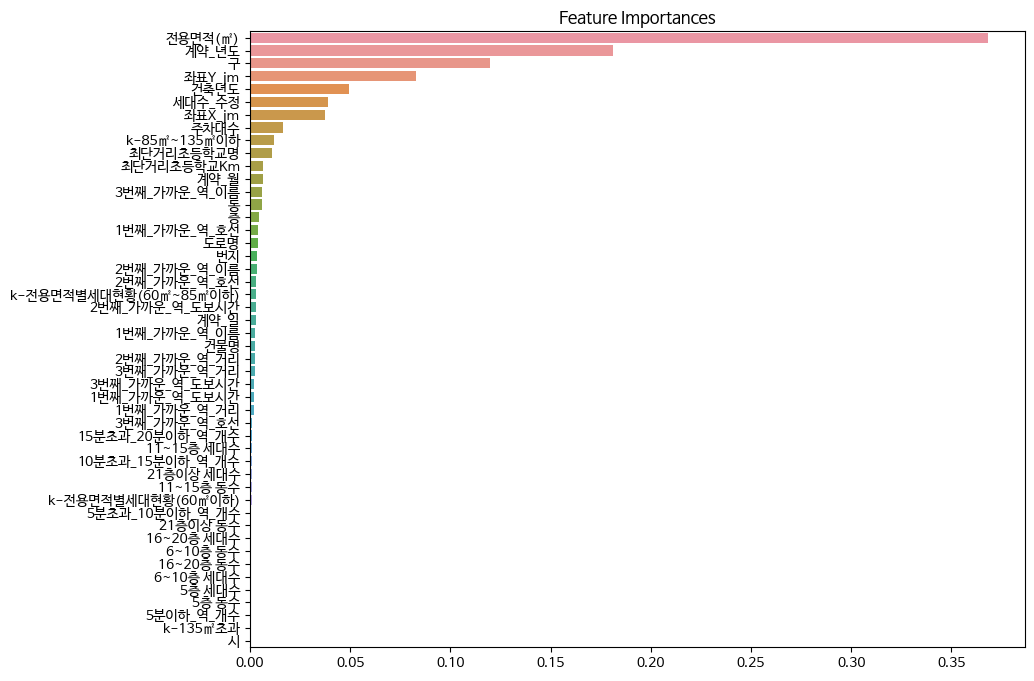

In [61]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model3.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

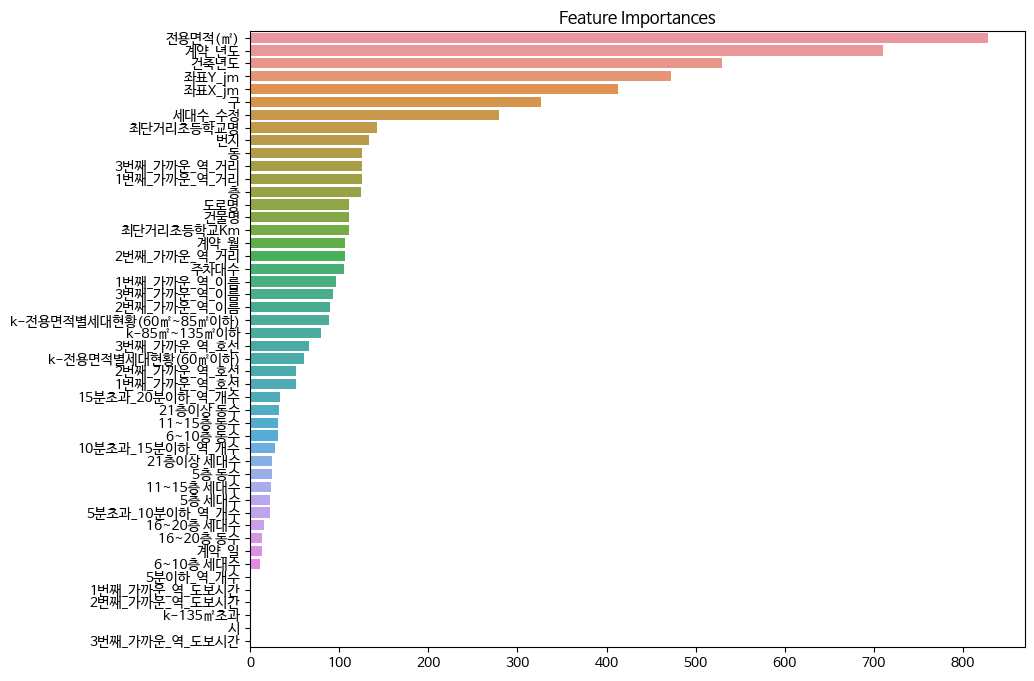

In [62]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model6_2_m.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [57]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model3,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1316623068.8070 ± 15227395.0051,전용면적(㎡)
1069917613.2043 ± 11942088.1319,계약_년도
728893323.2067 ± 1460751.6444,구
632474474.1545 ± 7467417.0821,좌표Y_jm
195296716.4143 ± 1930658.5537,좌표X_jm
192828145.1845 ± 3424898.9097,건축년도
160663783.7682 ± 1581280.2953,세대수_수정
69197694.0683 ± 6567354.5120,주차대수
44705251.4104 ± 2778556.4484,k-85㎡~135㎡이하
26771827.4784 ± 4066917.5834,최단거리초등학교명


In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)